In [129]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [130]:
words = open('../data/names.txt', 'r').read().splitlines()

In [131]:
len(words)

32033

In [132]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [133]:
chars = sorted(list(set(''.join(words))))

# util

In [134]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [135]:
stoi = {s: i for i, s in itos.items()}

# Build a neural language model

## prepare data

In [136]:
block_size = 3
X, Y = [], []
for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        # print(''.join([itos[i] for i in context]), '--->', itos[ix])
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]        

In [137]:
X = torch.tensor(X)
Y = torch.tensor(Y)        

In [138]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

## embedding matrix C

In [139]:
C = torch.randn(len(itos), 2)
C.shape

torch.Size([27, 2])

In [140]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

## hidden layer

In [141]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [142]:
h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh()
h.shape

torch.Size([228146, 100])

## final layer

In [143]:
w2 = torch.randn(100, len(itos))
b2 = torch.randn(len(itos))

In [144]:
logits = h @ w2 + b2
logits.shape

torch.Size([228146, 27])

In [145]:
loss = F.cross_entropy(logits, Y)
loss

tensor(16.3428)

# Train a neural language model

In [256]:
C = torch.randn(len(itos), 2)
w1 = torch.randn(6, 100)
b1 = torch.randn(100)
w2 = torch.randn(100, len(itos))
b2 = torch.randn(len(itos))
parameters = [C, w1, b1, w2, b2]

In [257]:
sum(p.nelement() for p in parameters)

3481

In [258]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
for _ in tqdm(range(30000)):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))
    Xb, Yb = X[ix], Y[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
    # tracking
    lossi.append(loss.item())

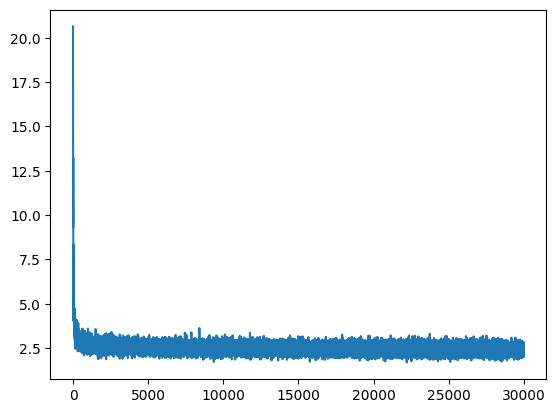

In [194]:
plt.plot(lossi)

In [195]:
lossi[-5:]

[2.478954792022705,
 2.389252185821533,
 2.0185036659240723,
 2.185878276824951,
 2.5676350593566895]

In [196]:
logits.shape

torch.Size([32, 27])

## compute loss on train

In [213]:
with torch.no_grad():
    emb = C[X] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

2.4019265174865723


## figuring out learning rate

In [259]:
lre = torch.linspace(-4, 1, 1000)
lrs = 10**lre

In [260]:
lossi = []
lri = []
for i in tqdm(range(1000)):
    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,))
    Xb, Yb = X[ix], Y[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    lri.append(lre[i])
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3581.01it/s]


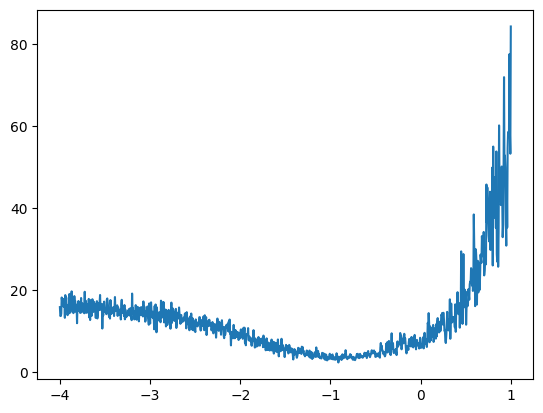

In [261]:
plt.plot(lri, lossi)